1) Carga de librerias necesarias

In [1]:
# Manipulación de Datos
import numpy as np
import pandas as pd

# Preprocesamiento
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# Modelado y Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import lightgbm as lgb

# Reducción de Dimensionalidad
import umap.umap_ as umap

# Validacion y Selección de Modelos
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

# Estadísticas y Optimización de Hiperparámetros
from scipy.stats import randint

# Métricas de Evaluación
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold

from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.impute import SimpleImputer

import gc

c:\Users\luiso\anaconda3\envs\fraud-detection-environment\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2) Carga de bases de datos

In [2]:
#Se guarda en variables los datos de los archivos csv
client_train = pd.read_csv('client_train.csv')
invoice_train = pd.read_csv('invoice_train.csv')

C:\Users\luiso\AppData\Local\Temp\ipykernel_19464\1930133614.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  invoice_train = pd.read_csv('invoice_train.csv')


In [3]:
# Total de datos
print(client_train.shape)
print(invoice_train.shape)

(135493, 6)
(4476749, 16)


3) Verificar Unicidad de client_id en bases de datos:

In [4]:
#En la base de datos client_train se cuenta el número de veces que se repite el id de un cliente
client_counts = client_train['client_id'].value_counts()
print(client_counts.head())

client_id
train_Client_0        1
train_Client_59347    1
train_Client_5936     1
train_Client_59359    1
train_Client_59358    1
Name: count, dtype: int64


In [5]:
#En la base de datos invoice_train se cuenta el número de veces que se repite el id de un cliente
invoice_counts = invoice_train['client_id'].value_counts()
print(invoice_counts.head())


client_id
train_Client_116878    439
train_Client_9263      380
train_Client_130245    327
train_Client_59131     317
train_Client_61728     310
Name: count, dtype: int64


4) Se contruye un historico de consumo

In [6]:
# Se convierte la variable 'invoice_date' a formato fecha 
invoice_train['invoice_date'] = pd.to_datetime(invoice_train['invoice_date'])

# Se ordena 'invoice_train' por 'client_id' y 'invoice_date'
invoice_train_sorted = invoice_train.sort_values(by=['client_id', 'invoice_date'])

# Se crea una variable que contiene el historico de facturación de cada cliente y los datos de la base de datos 'client_train'
historico_consumo = pd.merge(invoice_train_sorted, client_train, on='client_id', how='left')

5) Análisis Exploratorio de Datos (EDA)

In [7]:
# Total de datos
print(historico_consumo.shape)

(4476749, 21)


In [8]:
# Ajustar la opción de visualización para mostrar todas las columnas
pd.set_option('display.max_columns', None)

# Observar las primeras filas del DataFrame
historico_consumo.head(10)

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,disrict,client_catg,region,creation_date,target
0,train_Client_0,2005-10-17,11,1335667,0,203,6,1,124,0,0,0,3685,3809,4,ELEC,60,11,101,31/12/1994,0.0
1,train_Client_0,2006-02-24,11,1335667,0,203,6,1,141,0,0,0,3809,3950,4,ELEC,60,11,101,31/12/1994,0.0
2,train_Client_0,2006-06-23,11,1335667,0,203,6,1,162,0,0,0,3950,4112,4,ELEC,60,11,101,31/12/1994,0.0
3,train_Client_0,2006-10-18,11,1335667,0,203,6,1,159,0,0,0,4112,4271,4,ELEC,60,11,101,31/12/1994,0.0
4,train_Client_0,2007-02-26,11,1335667,0,203,6,1,182,0,0,0,4271,4453,4,ELEC,60,11,101,31/12/1994,0.0
5,train_Client_0,2007-06-27,11,1335667,0,203,6,1,240,0,0,0,4453,4693,4,ELEC,60,11,101,31/12/1994,0.0
6,train_Client_0,2007-10-25,11,1335667,0,203,6,1,276,0,0,0,4693,4969,4,ELEC,60,11,101,31/12/1994,0.0
7,train_Client_0,2008-01-04,11,1335667,0,203,6,1,277,0,0,0,4969,5246,4,ELEC,60,11,101,31/12/1994,0.0
8,train_Client_0,2008-07-28,11,1335667,0,203,6,1,171,0,0,0,5246,5417,4,ELEC,60,11,101,31/12/1994,0.0
9,train_Client_0,2008-11-25,11,1335667,0,203,6,1,174,0,0,0,5417,5591,4,ELEC,60,11,101,31/12/1994,0.0


In [9]:
# Se describe el historico de consumo
historico_consumo.describe()

,invoice_date,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,disrict,client_catg,region,target
count,4476749,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2013-03-18 07:42:34.444127232,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01,6.348246e+01,1.194381e+01,2.103584e+02,7.887688e-02
min,1977-06-09 00:00:00,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+01,1.100000e+01,1.010000e+02,0.000000e+00
25%,2010-01-19 00:00:00,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00,6.200000e+01,1.100000e+01,1.030000e+02,0.000000e+00
50%,2013-07-10 00:00:00,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00,6.200000e+01,1.100000e+01,3.010000e+02,0.000000e+00
75%,2016-09-03 00:00:00,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00,6.300000e+01,1.100000e+01,3.090000e+02,0.000000e+00
max,2019-12-07 00:00:00,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05,6.900000e+01,5.100000e+01,3.990000e+02,1.000000e+00
std,NaN,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03,3.273403e+00,6.022452e+00,1.035828e+02,2.695465e-01


In [10]:
# Se observa la distribución de las variables
historico_consumo.value_counts()

client_id            invoice_date  tarif_type  counter_number  counter_statue  counter_code  reading_remarque  counter_coefficient  consommation_level_1  consommation_level_2  consommation_level_3  consommation_level_4  old_index  new_index  months_number  counter_type  disrict  client_catg  region  creation_date  target
train_Client_66981   2006-07-17    11          132701          5               420           6                 1                    0                     0                     0                     0                     5946       5946       2              ELEC          63       51           313     20/11/1996     1.0       3
train_Client_3636    2012-01-18    40          312650          5               5             6                 1                    0                     0                     0                     0                     623        623        2              GAZ           60       11           101     21/11/1988     0.0       2
train_Client_7066    

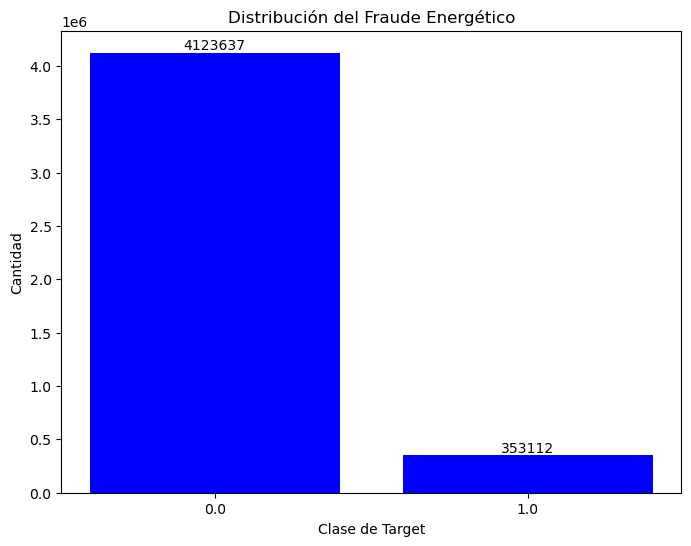

In [11]:
# Distribución de la variable 'target'
target_counts = historico_consumo['target'].value_counts()

# Creación del gráfico de barras
plt.figure(figsize=(8, 6))
bars = plt.bar(target_counts.index.astype(str), target_counts.values, color='blue')
plt.title('Distribución del Fraude Energético')
plt.xlabel('Clase de Target')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)  # Rotar las etiquetas del eje X para mejor legibilidad

# Añadir etiquetas de recuento encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, yval, ha='center', va='bottom')

plt.show()




6) Feature Creation

In [12]:
# 1. Consumo Total por Factura
historico_consumo['consumo_total'] = historico_consumo[['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4']].sum(axis=1)

# 2. Consumo Promedio Mensual
historico_consumo['consumo_promedio_mensual'] = historico_consumo.groupby('client_id')['consumo_total'].transform(lambda x: x.mean())

#3. Desviación Estándar del Consumo
historico_consumo['desviacion_std_consumo'] = historico_consumo.groupby('client_id')['consumo_total'].transform(lambda x: x.std())

#4. Variación de Consumo entre Facturas Consecutivas
historico_consumo = historico_consumo.sort_values(by=['client_id', 'invoice_date'])
historico_consumo['variacion_consumo'] = historico_consumo.groupby('client_id')['consumo_total'].diff()

#5. Ratio de Consumo entre Niveles
historico_consumo['ratio_level_1'] = historico_consumo['consommation_level_1'] / historico_consumo['consumo_total']
historico_consumo['ratio_level_2'] = historico_consumo['consommation_level_2'] / historico_consumo['consumo_total']
historico_consumo['ratio_level_3'] = historico_consumo['consommation_level_3'] / historico_consumo['consumo_total']
historico_consumo['ratio_level_4'] = historico_consumo['consommation_level_4'] / historico_consumo['consumo_total']

# 6. Días entre Facturas
historico_consumo['dias_entre_facturas'] = historico_consumo.groupby('client_id')['invoice_date'].diff().dt.days

# 7. Se eliminan las columnas de consunmo originales
historico_consumo = historico_consumo.drop(['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4'], axis=1)

# Se observan los cambios
historico_consumo.head(10)

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,old_index,new_index,months_number,counter_type,disrict,client_catg,region,creation_date,target,consumo_total,consumo_promedio_mensual,desviacion_std_consumo,variacion_consumo,ratio_level_1,ratio_level_2,ratio_level_3,ratio_level_4,dias_entre_facturas
0,train_Client_0,2005-10-17,11,1335667,0,203,6,1,3685,3809,4,ELEC,60,11,101,31/12/1994,0.0,124,362.971429,341.55393,NaN,1.0,0.0,0.0,0.0,NaN
1,train_Client_0,2006-02-24,11,1335667,0,203,6,1,3809,3950,4,ELEC,60,11,101,31/12/1994,0.0,141,362.971429,341.55393,17.0,1.0,0.0,0.0,0.0,130.0
2,train_Client_0,2006-06-23,11,1335667,0,203,6,1,3950,4112,4,ELEC,60,11,101,31/12/1994,0.0,162,362.971429,341.55393,21.0,1.0,0.0,0.0,0.0,119.0
3,train_Client_0,2006-10-18,11,1335667,0,203,6,1,4112,4271,4,ELEC,60,11,101,31/12/1994,0.0,159,362.971429,341.55393,-3.0,1.0,0.0,0.0,0.0,117.0
4,train_Client_0,2007-02-26,11,1335667,0,203,6,1,4271,4453,4,ELEC,60,11,101,31/12/1994,0.0,182,362.971429,341.55393,23.0,1.0,0.0,0.0,0.0,131.0
5,train_Client_0,2007-06-27,11,1335667,0,203,6,1,4453,4693,4,ELEC,60,11,101,31/12/1994,0.0,240,362.971429,341.55393,58.0,1.0,0.0,0.0,0.0,121.0
6,train_Client_0,2007-10-25,11,1335667,0,203,6,1,4693,4969,4,ELEC,60,11,101,31/12/1994,0.0,276,362.971429,341.55393,36.0,1.0,0.0,0.0,0.0,120.0
7,train_Client_0,2008-01-04,11,1335667,0,203,6,1,4969,5246,4,ELEC,60,11,101,31/12/1994,0.0,277,362.971429,341.55393,1.0,1.0,0.0,0.0,0.0,71.0
8,train_Client_0,2008-07-28,11,1335667,0,203,6,1,5246,5417,4,ELEC,60,11,101,31/12/1994,0.0,171,362.971429,341.55393,-106.0,1.0,0.0,0.0,0.0,206.0
9,train_Client_0,2008-11-25,11,1335667,0,203,6,1,5417,5591,4,ELEC,60,11,101,31/12/1994,0.0,174,362.971429,341.55393,3.0,1.0,0.0,0.0,0.0,120.0


7. Feature Engeniering

In [13]:
#Se eliminan las columnas que no se utilizarán
historico_consumo = historico_consumo.drop(['invoice_date', 'creation_date'], axis=1)

# Lista de columnas categóricas para convertir a formato numérico mediante One-Hot Encoding
columns_to_encode = ['tarif_type', 'counter_statue', 'counter_code', 'reading_remarque', 'client_catg', 'region', 'counter_type']

# Inicializa el codificador de etiquetas
label_encoder = LabelEncoder()

# Ajusta el codificador de etiquetas al 'client_id' y transforma 'client_id' a valores numéricos
historico_consumo['client_id_encoded'] = label_encoder.fit_transform(historico_consumo['client_id'])

# Se elimina la columna 'client_id' original
historico_consumo = historico_consumo.drop(['client_id'], axis=1)

# Aplica la codificación One-Hot a 'historico_consumo'
historico_consumo_encoded = pd.get_dummies(historico_consumo, columns=columns_to_encode)


In [14]:
# Se observan los cambios
with pd.option_context('display.max_rows', None):
    print(historico_consumo_encoded.dtypes)


counter_number                int64
counter_coefficient           int64
old_index                     int64
new_index                     int64
months_number                 int64
disrict                       int64
target                      float64
consumo_total                 int64
consumo_promedio_mensual    float64
desviacion_std_consumo      float64
variacion_consumo           float64
ratio_level_1               float64
ratio_level_2               float64
ratio_level_3               float64
ratio_level_4               float64
dias_entre_facturas         float64
client_id_encoded             int32
tarif_type_8                   bool
tarif_type_9                   bool
tarif_type_10                  bool
tarif_type_11                  bool
tarif_type_12                  bool
tarif_type_13                  bool
tarif_type_14                  bool
tarif_type_15                  bool
tarif_type_18                  bool
tarif_type_21                  bool
tarif_type_24               

7.1 Se imputan datos para eliminar missing values

In [15]:
# Crear un objeto imputador con la estrategia de reemplazo por la mediana
imputer = SimpleImputer(strategy='median')

# Aplicar la imputación al DataFrame
columns_to_impute = historico_consumo_encoded.select_dtypes(include=['int64', 'float64']).columns
historico_consumo_encoded[columns_to_impute] = imputer.fit_transform(historico_consumo_encoded[columns_to_impute])

# Se verifica si aún quedan valores NaN
with pd.option_context('display.max_rows', None):
    print(historico_consumo_encoded.isnull().sum())

counter_number              0
counter_coefficient         0
old_index                   0
new_index                   0
months_number               0
disrict                     0
target                      0
consumo_total               0
consumo_promedio_mensual    0
desviacion_std_consumo      0
variacion_consumo           0
ratio_level_1               0
ratio_level_2               0
ratio_level_3               0
ratio_level_4               0
dias_entre_facturas         0
client_id_encoded           0
tarif_type_8                0
tarif_type_9                0
tarif_type_10               0
tarif_type_11               0
tarif_type_12               0
tarif_type_13               0
tarif_type_14               0
tarif_type_15               0
tarif_type_18               0
tarif_type_21               0
tarif_type_24               0
tarif_type_27               0
tarif_type_29               0
tarif_type_30               0
tarif_type_40               0
tarif_type_42               0
tarif_type

8. Entrenamiento de un desition tree

In [16]:
# Validacion cruzada con agrupación (Para evitar fuga de información)
groups = historico_consumo_encoded['client_id_encoded'].values
X = historico_consumo_encoded.drop(['target', 'client_id_encoded'], axis=1).values
y = historico_consumo_encoded['target'].values

gkf = GroupKFold(n_splits=5)

for train_idx, test_idx in gkf.split(X, y, groups):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]


Accuracy: 0.9258222212790767
Precision: 0.8991360691144709
Recall: 0.05937727318109855


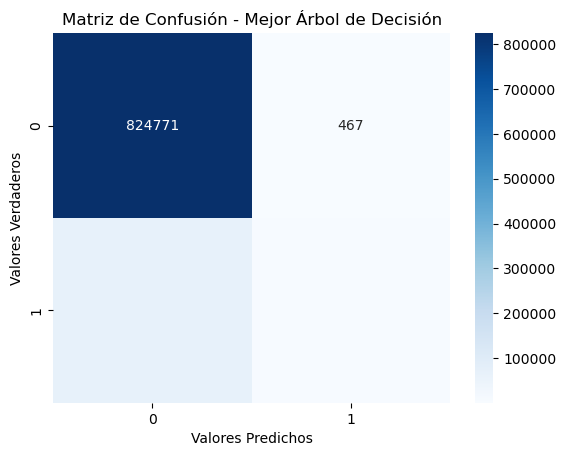

In [17]:
# Se definen los hiperparámetros de la búsqueda
param_grid = {
    'criterion': ['gini', 'entropy'],  # Función para medir el grado de impureza de un nodo
    'max_depth': [10, 20, 30],  # Profundidades limitadas para evitar el sobreajuste y reducir el tiempo de cálculo
    'min_samples_split': [2, 4],  # Número mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2]  # Número mínimo de muestras requeridas en un nodo hoja
}

# Inicializar el clasificador
clf = DecisionTreeClassifier(random_state=42)

# Configurar la búsqueda de parámetros con validación cruzada
gkf = GroupKFold(n_splits=5)
grid_search = GridSearchCV(clf, param_grid, cv=gkf, scoring='precision', n_jobs=4)

# Preparar los grupos para la validación cruzada
groups = historico_consumo_encoded['client_id_encoded'].values

# Ejecutar la búsqueda de parámetros
grid_search.fit(X, y, groups=groups)

# Mejor modelo encontrado
best_clf = grid_search.best_estimator_

# Realizar predicciones con el mejor modelo
y_pred = best_clf.predict(X_test)

# Calcular las métricas de rendimiento
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Se obtienen los mejores parámetros
mejores_parametros = grid_search.best_params_
print("Mejores parámetros:", mejores_parametros)

# Imprimir los resultados del rendimiento
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

# Generar y mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Valores Predichos')
plt.ylabel('Valores Verdaderos')
plt.title('Matriz de Confusión Decision Tree Classifier (Mejor Modelo: Precisión)')
plt.show()

In [ ]:
# Se eliminan las variables que no se utilizarán para continuar con el analisis de datos
del x , y, X_train, X_test, y_train, y_test, train_idx, test_idx, groups, gkf, grid_search, best_clf, y_pred, accuracy, precision, recall, conf_matrix
gc.collect()

9. Balanceo del dataset mediante Undersampling con NearMiss

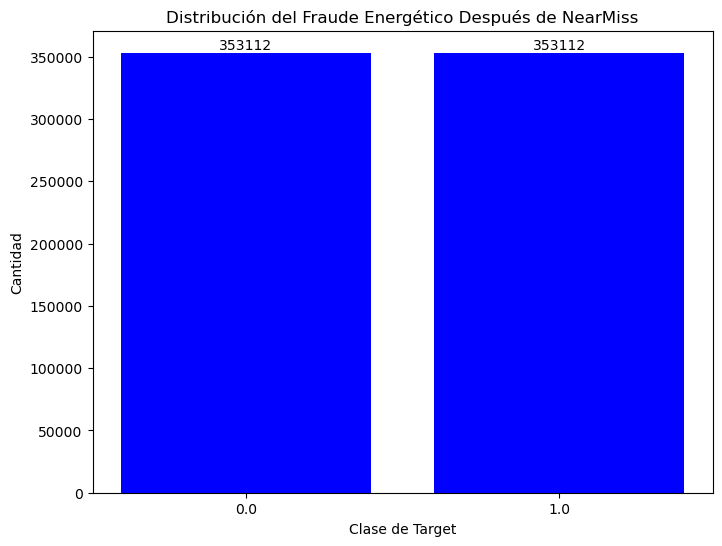

In [18]:
X = historico_consumo_encoded.drop(['target'], axis=1)
y = historico_consumo_encoded['target']

# Inicializar el objeto de undersampling con NearMiss
undersampler = NearMiss()

# Aplicar undersampling a tus datos
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Conteo de la variable 'target' después del undersampling
target_counts = y_resampled.value_counts()

# Creación del gráfico de barras
plt.figure(figsize=(8, 6))
bars = plt.bar(target_counts.index.astype(str), target_counts.values, color='blue')
plt.title('Distribución del Fraude Energético Después de NearMiss')
plt.xlabel('Clase de Target')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)  # Rotar las etiquetas del eje X para mejor legibilidad

# Añadir etiquetas de recuento encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, yval, ha='center', va='bottom')

plt.show()



10. Reduccion de dimensionalidad

c:\Users\luiso\anaconda3\envs\fraud-detection-environment\lib\site-packages\sklearn\manifold\_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Número original de características: 129
Número reducido de características: 2


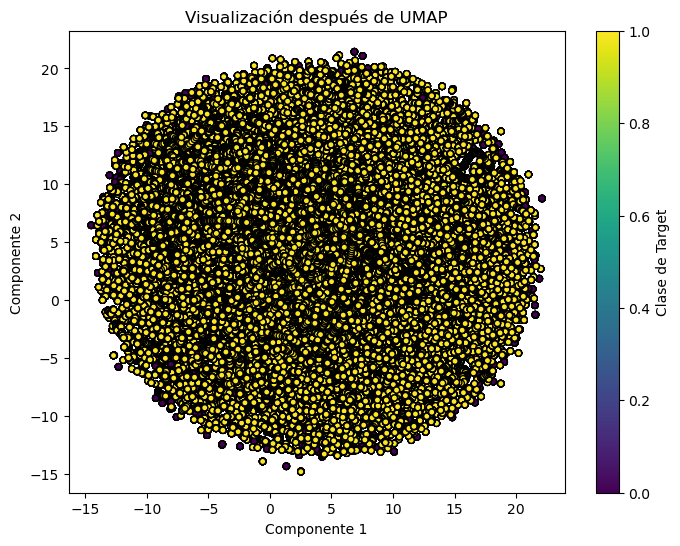

In [19]:
# Aplicar UMAP para reducir la dimensionalidad
reducer = umap.UMAP(random_state=42)
X_resampled_umap = reducer.fit_transform(X_resampled)

# Mostrar el resultado de la reducción de dimensionalidad
print(f'Número original de características: {X_resampled.shape[1]}')
print(f'Número reducido de características: {X_resampled_umap.shape[1]}')

# Visualizar las dos primeras componentes principales
plt.figure(figsize=(8, 6))
plt.scatter(X_resampled_umap[:, 0], X_resampled_umap[:, 1], c=y_resampled, cmap='viridis', edgecolor='k', s=20)
plt.title('Visualización después de UMAP')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.colorbar(label='Clase de Target')
plt.show()


11. Estandarización de datos

c:\Users\luiso\anaconda3\envs\fraud-detection-environment\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


MemoryError: Unable to allocate 9.74 GiB for an array with shape (1307440501,) and data type float64

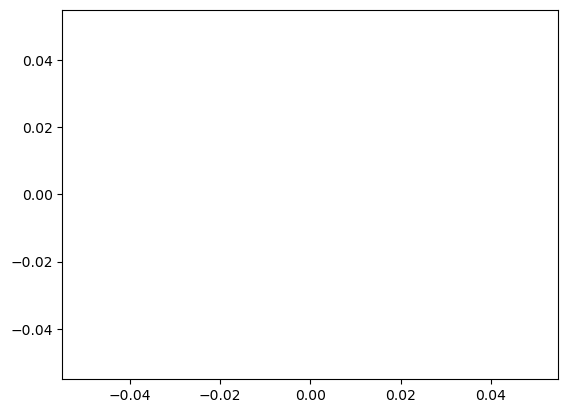

In [20]:
# Convertir tipos de datos para optimizar el uso de memoria
X_optimizado = X_resampled.astype({col: 'float32' for col in X_resampled.select_dtypes(include=['float64']).columns})
X_optimizado = X_optimizado.astype({col: 'int32' for col in X_optimizado.select_dtypes(include=['int64']).columns})

# Inicializar el objeto StandardScaler para estandarizar los datos
scaler = StandardScaler()

# Identificar las columnas numéricas en X_optimizado para la estandarización
columnas_numericas = X_optimizado.select_dtypes(include=['float32', 'int32']).columns

# Estandarizar las columnas numéricas de X_optimizado
X_optimizado[columnas_numericas] = scaler.fit_transform(X_optimizado[columnas_numericas])

# Seleccionar una columna para visualizar su distribución después de la estandarización
columna_visualizar = columnas_numericas[0]

# Generar un histograma para la columna seleccionada
sns.histplot(X_optimizado[columna_visualizar], kde=True)
plt.title(f'Distribución de {columna_visualizar} tras estandarización')
plt.xlabel(columna_visualizar)
plt.ylabel('Frecuencia')
plt.show()


12. Guardado de nueva base de datos

In [ ]:
#Se guarda la base de datos generada 
# Primero, convierte 'y_resampled' de nuevo a un DataFrame para poder concatenarlo con X_optimizado
y_resampled_df = pd.DataFrame(y_resampled, columns=['target'])

# Concatena las características y las etiquetas en un nuevo DataFrame
datos_finales = pd.concat([X_optimizado, y_resampled_df], axis=1)

# Especifica el nombre del archivo donde deseas guardar la nueva base de datos
nombre_archivo = 'historico_consumo_undersampling_reduccionDimensionalidad_estandarizado.csv'

# Guarda el DataFrame como un archivo CSV
datos_finales.to_csv(nombre_archivo, index=False)

print(f'Datos guardados como {nombre_archivo}')


In [ ]:
# Se carga la base de datos
historico_consumo_editado = pd.read_csv('historico_consumo_undersampling_reduccionDimensionalidad_estandarizado.csv')
historico_consumo_editado.head()